In [31]:
#!pip install -q git+https://github.com/tensorflow/docs

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
print(tf.__version__)

2.0.0


In [30]:
#!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import dvfdata
df_prepared=dvfdata.loadDVF_Maisons(departement='77',refresh_force=False,add_commune=False)

Read Mutations
Read Local
Read Parcelle
Read Adresse
Make the join for DVF
Filter data:
Final Calculations


In [10]:
# Remove the extreme value : more than 100 M€.
df_filtered=df_prepared[df_prepared['valeurfonc']<1000000].copy()
df_filtered = df_filtered[df_filtered["sterr"]<=10000]
# Transform
X_drop = df_filtered.drop(columns=['n_days','quartier','commune','communelabel','departement','codepostal'])

Index(['valeurfonc', 'sterr', 'geolong', 'geolat', 'nbpprinc', 'sbati'], dtype='object')
Index([], dtype='object')


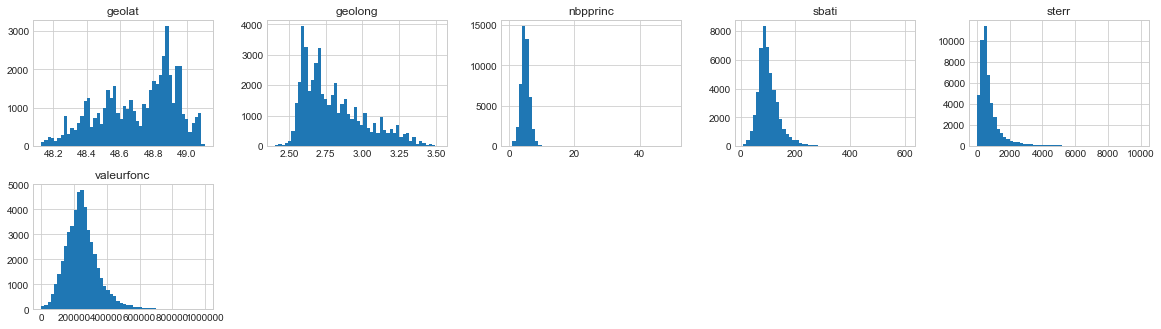

In [11]:
num_cols = X_drop.select_dtypes([np.number]).columns
print (num_cols)

# Analyze Categorical Columns
cat_col= X_drop.select_dtypes([np.object]).columns
print (cat_col)

#fig, ax = plt.subplots()
#ax = X_drop.plot.barh(x='Fidélité')
X_drop.hist(bins=50,layout=(200,5),figsize=(20,600));

In [44]:
X_drop["valeurfonc"]=X_drop["valeurfonc"].astype(float)
X_drop["sterr"]=X_drop["sterr"].astype(float)
X_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47724 entries, 1468387 to 1516439
Data columns (total 6 columns):
valeurfonc    47724 non-null float64
sterr         47724 non-null float64
geolong       47500 non-null float64
geolat        47500 non-null float64
nbpprinc      47724 non-null float64
sbati         47724 non-null float64
dtypes: float64(6)
memory usage: 3.8 MB


In [45]:
from sklearn.model_selection import train_test_split

# Exclude the Target predicted variable from to create the X and y
X_df = X_drop.drop(columns='valeurfonc')
y = df_filtered['valeurfonc']

/Users/christophenoblanc/anaconda3/envs/dssp_projet_dvf/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/christophenoblanc/anaconda3/envs/dssp_projet_dvf/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


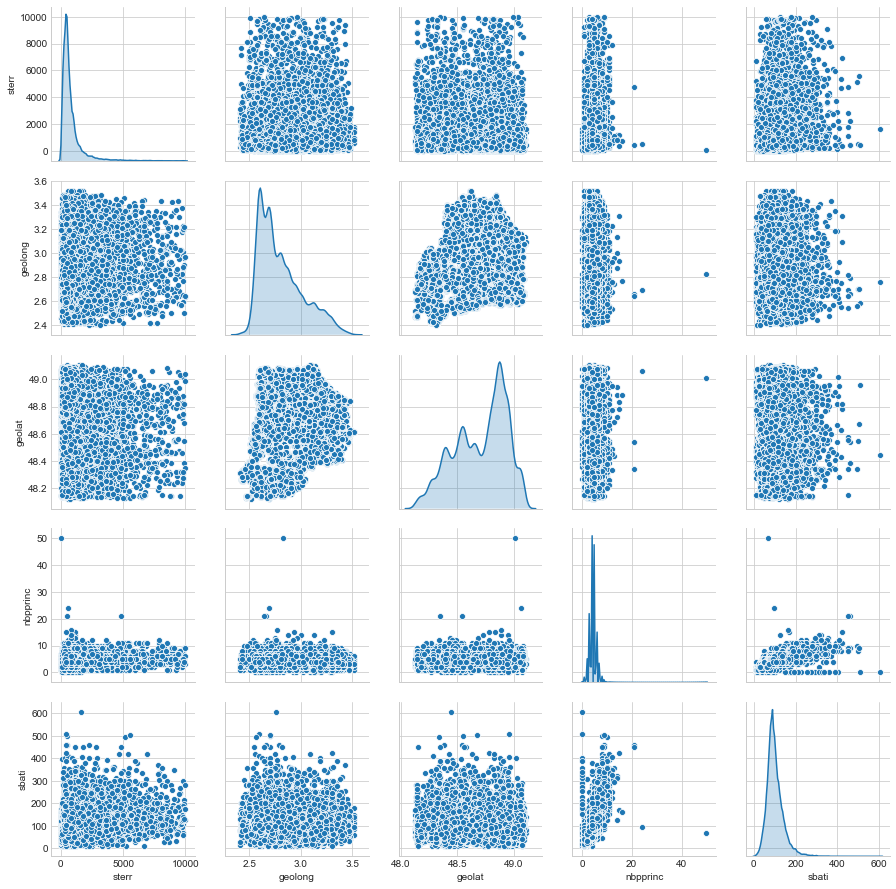

In [46]:
sns.pairplot(X_df, diag_kind="kde")

In [47]:
#from sklearn.preprocessing import Normalizer
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Exclude the Target predicted variable from to create the X and y
X_df = X_drop.drop(columns='valeurfonc')
y = df_filtered['valeurfonc']


columns = X_df.columns
num_cols = X_df.select_dtypes([np.number]).columns
cat_col= X_df.select_dtypes([np.object]).columns

# Split data Train & Test
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2,random_state=42)

In [48]:
train_stats = X_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
sterr,38179.0,823.281857,967.614251,1.000000,344.000000,546.000000,924.500000,9997.000000
geolong,37994.0,2.804922,0.211608,2.405077,2.630054,2.745408,2.930743,3.517611
geolat,37994.0,48.708326,0.228760,48.125375,48.530369,48.768895,48.888636,49.108643
nbpprinc,38179.0,4.441918,1.382975,0.000000,4.000000,4.000000,5.000000,50.000000
sbati,38179.0,101.530082,39.624105,9.000000,77.000000,95.000000,120.000000,605.000000


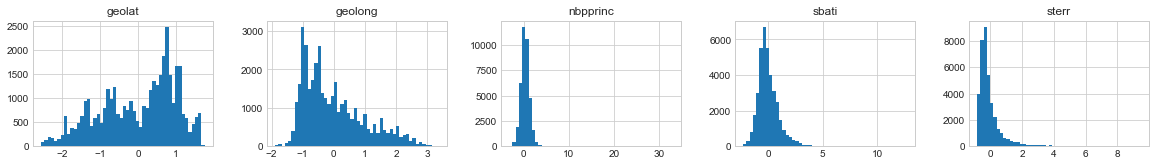

In [49]:
# Normalize Features
def norm_feature(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_X_train = norm_feature(X_train)
normed_X_test = norm_feature(X_test)

normed_X_train.hist(bins=50,layout=(200,5),figsize=(20,600));

In [50]:
normed_X_train.keys()

Index(['sterr', 'geolong', 'geolat', 'nbpprinc', 'sbati'], dtype='object')

In [78]:
from tensorflow.keras.optimizers import SGD

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[normed_X_train.shape[1]]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer=SGD(lr=0.01, momentum=0.9)
    #optimizer='rmsprop'

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Take en example of a batch of 10 first training rows
#example_batch = normed_X_train[:10]
#example_result = model.predict(example_batch)
#example_result

In [80]:
normed_X_train

,sterr,geolong,geolat,nbpprinc,sbati
1488389,-0.318600,-0.976176,0.839427,-0.319542,-0.795730
1483772,-0.247291,-0.516172,-0.690217,0.403537,-0.316224
1480271,-0.418847,0.404842,1.065349,-0.319542,-0.947153
1490448,-0.436415,-0.949213,0.435326,-0.319542,-0.644307
1509063,-0.716486,-0.309208,0.645457,0.403537,0.138045
...,...,...,...,...,...
1479752,0.198135,2.609240,-0.754737,-1.042621,-0.265749
1513422,-0.287596,-0.468081,0.588783,1.126616,1.425141
1506806,0.714870,-0.465740,0.728785,3.295854,2.737473
1469251,0.025545,-0.009467,-1.383536,-0.319542,-0.770493


In [81]:
y_train

1488389    235000
1483772    273300
1480271    215000
1490448    280000
1509063    282000
            ...  
1479752     90000
1513422    460000
1506806    830000
1469251    182000
1484302    205000
Name: valeurfonc, Length: 38179, dtype: int64

In [82]:
EPOCHS = 10

history = model.fit(normed_X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Train on 30543 samples, validate on 7636 samples
Epoch 1/10
30543/30543 [==============================] - 3s 90us/sample - loss: nan - mean_absolute_error: nan - mean_squared_error: nan - val_loss: nan - val_mean_absolute_error: nan - val_mean_squared_error: nan
Epoch 2/10
30543/30543 [==============================] - 2s 71us/sample - loss: nan - mean_absolute_error: nan - mean_squared_error: nan - val_loss: nan - val_mean_absolute_error: nan - val_mean_squared_error: nan
Epoch 3/10
30240/30543 [============================>.] - ETA: 0s - loss: nan - mean_absolute_error: nan - mean_squared_error: nan

KeyboardInterrupt: 

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [ ]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 20])
plt.ylabel('MAE [MPG]')

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_X_train, y_train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

In [ ]:
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")